# DX 704 Week 9 Project

This week's project will build an email spam classifier based on the Enron email data set.
You will perform your own feature extraction, and use naive Bayes to estimate the probability that a particular email is spam or not.
Finally, you will review the tradeoffs from different thresholds for automatically sending emails to the junk folder.

The full project description and a template notebook are available on GitHub: [Project 9 Materials](https://github.com/bu-cds-dx704/dx704-project-09).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Download Data Set

We will be using the Enron spam data set as prepared in this GitHub repository.

https://github.com/MWiechmann/enron_spam_data

You may need to download this differently depending on your environment.

In [1]:
!wget https://github.com/MWiechmann/enron_spam_data/raw/refs/heads/master/enron_spam_data.zip

zsh:1: command not found: wget


In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Text feature extraction
from sklearn.feature_extraction.text import CountVectorizer

# Model building and evaluation
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [3]:
# pandas can read the zip file directly
enron_spam_data = pd.read_csv("enron_spam_data.zip")
enron_spam_data

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


In [4]:
(enron_spam_data["Spam/Ham"] == "spam").mean()

np.float64(0.5092834262664611)

## Part 2: Design a Feature Extractor

Design a feature extractor for this data set and write out two files of features based on the text.
Don't forget that both the Subject and Message columns are relevant sources of text data.
For each email, you should count the number of repetitions of each feature present.
The auto-grader will assume that you are using a multinomial distribution in the following problems.

In [5]:
# Combine Subject and Message into a single text field
# Give subject extra weight since spam signals often appear there
enron_spam_data['combined_text'] = (
    enron_spam_data['Subject'].fillna('') + ' ' + 
    enron_spam_data['Message'].fillna('')
)

# Configure CountVectorizer for basic feature extraction
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    analyzer='word',
    max_features=10000
)

# Fit and transform on the combined text
feature_matrix = vectorizer.fit_transform(enron_spam_data['combined_text'])
feature_names = vectorizer.get_feature_names_out()

print(f"Extracted {len(feature_names)} features")
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Sample features: {list(feature_names[-20:])}")
print(f"\nSample bigrams: {[f for f in feature_names if ' ' in f][:10]}")

Extracted 10000 features
Feature matrix shape: (33716, 10000)
Sample features: ['your tongue', 'your urgent', 'your web', 'your website', 'your winning', 'yours', 'yours sincerely', 'yourself', 'yourself and', 'ypil', 'zero', 'zhiyong', 'zimbabwe', 'zimin', 'zimin lu', 'zip', 'zone', 'zone www', 'zonedubai', 'zonedubai uae']

Sample bigrams: ['00 00', '00 20', '00 25', '00 32', '00 60', '00 90', '00 am', '00 and', '00 per', '00 pm']


Assign a row to the test data set if `Message ID % 30 == 0` and assign it to the training data set otherwise.
Write two files, "train-features.tsv" and "test-features.tsv" with two columns, Message ID and features_json.
The features_json column should contain a JSON dictionary where the keys are your feature names and the values are integer feature values.
This will give us a sparse feature representation.


In [6]:
# Split data: test if Message ID % 30 == 0, otherwise train
train_mask = enron_spam_data['Message ID'] % 30 != 0
test_mask = enron_spam_data['Message ID'] % 30 == 0

train_data = enron_spam_data[train_mask].copy()
test_data = enron_spam_data[test_mask].copy()

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Convert feature matrix to sparse JSON format
def create_features_json(feature_matrix, feature_names):
    """Convert scipy sparse matrix to list of JSON dictionaries with non-zero counts"""
    features_list = []
    
    for i in range(feature_matrix.shape[0]):
        # Get non-zero features for this row
        row = feature_matrix[i]
        non_zero_indices = row.nonzero()[1]
        
        # Create dictionary with feature names and counts
        feature_dict = {
            feature_names[idx]: int(row[0, idx])
            for idx in non_zero_indices
        }
        
        features_list.append(json.dumps(feature_dict))
    
    return features_list

# Get feature indices for train and test splits
train_indices = train_data.index
test_indices = test_data.index

# Create features JSON for train and test
train_features_json = create_features_json(feature_matrix[train_indices], feature_names)
test_features_json = create_features_json(feature_matrix[test_indices], feature_names)

# Create DataFrames with Message ID and features_json
train_output = pd.DataFrame({
    'Message ID': train_data['Message ID'].values,
    'features_json': train_features_json
})

test_output = pd.DataFrame({
    'Message ID': test_data['Message ID'].values,
    'features_json': test_features_json
})

# Save to TSV files
train_output.to_csv('submission/train-features.tsv', sep='\t', index=False)
test_output.to_csv('submission/test-features.tsv', sep='\t', index=False)


Training samples: 32592
Test samples: 1124


In [7]:
print("\nSample train features:")
print(train_output.head(3))
print(f"\nSample feature JSON: {train_features_json[0][:200]}...")

print("\nSample test features:")
print(test_output.head(3))
print(f"\nSample feature JSON: {test_features_json[0][:200]}...")


Sample train features:
   Message ID                                      features_json
0           1  {"resources": 4, "inc": 4, "gary": 2, "product...
1           2  {"nomination": 2, "gas": 2, "calpine": 2, "dai...
2           3  {"from": 3, "on": 4, "at": 1, "10": 3, "for": ...

Sample feature JSON: {"resources": 4, "inc": 4, "gary": 2, "production": 3, "from": 3, "the": 8, "high": 2, "island": 2, "larger": 2, "block": 2, "on": 7, "saturday": 1, "at": 3, "00": 2, "about": 1, "500": 4, "gross": 3,...

Sample test features:
   Message ID                                      features_json
0           0         {"christmas": 1, "farm": 1, "pictures": 1}
1          30  {"christmas": 1, "production": 3, "from": 1, "...
2          60  {"the": 1, "of": 1, "by": 1, "please": 1, "cal...

Sample feature JSON: {"christmas": 1, "farm": 1, "pictures": 1}...


Submit "train-features.tsv" and "test-features.tsv" in Gradescope.

Hint: these features will be graded based on the test accuracy of a logistic regression based on the training features.
This is to make sure that your feature set is not degenerate; you do not need to compute this regression yourself.
You can separately assess your feature quality based on your results in part 6.

## Part 3: Compute Conditional Probabilities

Based on your training data, compute appropriate conditional probabilities for use with naïve Bayes.
Use of additive smoothing with $\alpha=1$ to avoid zeros.


In [8]:
# Compute conditional probabilities P(feature|class) with Laplace smoothing (alpha=1)

# Separate training data by class (get boolean arrays for spam/ham)
train_spam_mask = (train_data['Spam/Ham'] == 'spam').values
train_ham_mask = (train_data['Spam/Ham'] == 'ham').values

# Get the training feature matrix
train_feature_matrix = feature_matrix[train_indices]

# Get feature counts for each class using boolean indexing
spam_feature_matrix = train_feature_matrix[train_spam_mask]
ham_feature_matrix = train_feature_matrix[train_ham_mask]

# Sum feature counts across all documents in each class
spam_feature_counts = np.array(spam_feature_matrix.sum(axis=0)).flatten()
ham_feature_counts = np.array(ham_feature_matrix.sum(axis=0)).flatten()

# Apply Laplace smoothing: P(feature|class) = (count + alpha) / (total_count + alpha * vocab_size)
alpha = 1.0
vocab_size = len(feature_names)

# Total word counts in each class (sum of all feature counts)
total_spam_words = spam_feature_counts.sum()
total_ham_words = ham_feature_counts.sum()

# Compute conditional probabilities with smoothing
spam_probabilities = (spam_feature_counts + alpha) / (total_spam_words + alpha * vocab_size)
ham_probabilities = (ham_feature_counts + alpha) / (total_ham_words + alpha * vocab_size)

print(f"Total spam emails: {train_spam_mask.sum()}")
print(f"Total ham emails: {train_ham_mask.sum()}")
print(f"Total words in spam: {total_spam_words}")
print(f"Total words in ham: {total_ham_words}")
print(f"Vocabulary size: {vocab_size}")

Total spam emails: 16599
Total ham emails: 15993
Total words in spam: 3618866
Total words in ham: 4964866
Vocabulary size: 10000


Save the conditional probabilities in a file "feature-probabilities.tsv" with columns feature, ham_probability and spam_probability.

In [9]:
# Save the conditional probabilities to a TSV file
feature_prob_df = pd.DataFrame({
    'feature': feature_names,
    'ham_probability': ham_probabilities,
    'spam_probability': spam_probabilities
})

# Display some interesting features
print("\nTop 10 most spam-indicative features:")
spam_ratio = spam_probabilities / (ham_probabilities + 1e-10)
top_spam_idx = np.argsort(spam_ratio)[-10:][::-1]
for idx in top_spam_idx:
    print(f"  {feature_names[idx]}: P(spam)={spam_probabilities[idx]:.6f}, P(ham)={ham_probabilities[idx]:.6f}")

print("\nTop 10 most ham-indicative features:")
ham_ratio = ham_probabilities / (spam_probabilities + 1e-10)
top_ham_idx = np.argsort(ham_ratio)[-10:][::-1]
for idx in top_ham_idx:
    print(f"  {feature_names[idx]}: P(spam)={spam_probabilities[idx]:.6f}, P(ham)={ham_probabilities[idx]:.6f}")


Top 10 most spam-indicative features:
  pills: P(spam)=0.000497, P(ham)=0.000000
  viagra: P(spam)=0.000455, P(ham)=0.000000
  cialis: P(spam)=0.000312, P(ham)=0.000000
  computron: P(spam)=0.000286, P(ham)=0.000000
  voip: P(spam)=0.000269, P(ham)=0.000000
  me com: P(spam)=0.000236, P(ham)=0.000000
  computron me: P(spam)=0.000236, P(ham)=0.000000
  ooking: P(spam)=0.000218, P(ham)=0.000000
  nbsp: P(spam)=0.000213, P(ham)=0.000000
  mx 2004: P(spam)=0.000213, P(ham)=0.000000

Top 10 most ham-indicative features:
  hou ect: P(spam)=0.000000, P(ham)=0.003178
  ect ect: P(spam)=0.000000, P(ham)=0.003087
  enron: P(spam)=0.000001, P(ham)=0.011881
  enron enron: P(spam)=0.000000, P(ham)=0.001209
  dynegy: P(spam)=0.000000, P(ham)=0.000951
  kaminski: P(spam)=0.000000, P(ham)=0.000940
  enron com: P(spam)=0.000000, P(ham)=0.000885
  vince kaminski: P(spam)=0.000000, P(ham)=0.000805
  ect cc: P(spam)=0.000000, P(ham)=0.000733
  corp enron: P(spam)=0.000000, P(ham)=0.000620


In [10]:
feature_prob_df.to_csv('submission/feature-probabilities.tsv', sep='\t', index=False)

Submit "feature-probabilities.tsv" in Gradescope.

## Part 4: Implement a Naïve Bayes Classifier

Implement a naïve Bayes classifier based on your previous feature probabilities.

Computing predictions for training data...
Training accuracy: 0.9772
Training accuracy: 0.9772


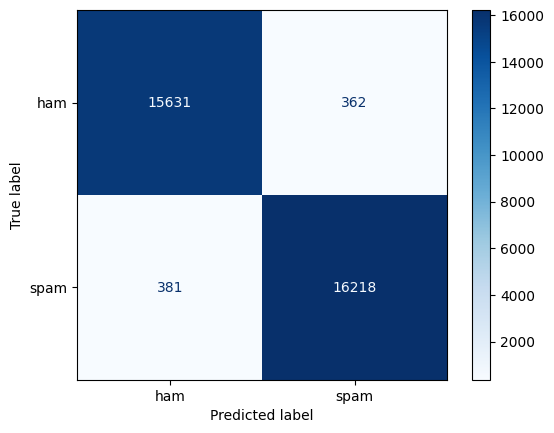

In [11]:
# Implement Naïve Bayes classifier using the conditional probabilities from Part 3

def naive_bayes_predict(feature_matrix, feature_probs_df, class_priors=None):
    """
    Predict class probabilities using Naïve Bayes with multinomial model.
    
    Args:
        feature_matrix: sparse matrix of feature counts (n_samples x n_features)
        feature_probs_df: DataFrame with columns ['feature', 'ham_probability', 'spam_probability']
        class_priors: dict with prior probabilities for each class (if None, uses training proportions)
    
    Returns:
        DataFrame with columns ['ham', 'spam'] containing class probabilities
    """
    n_samples = feature_matrix.shape[0]
    
    # Get conditional probabilities as arrays
    ham_probs = feature_probs_df['ham_probability'].values
    spam_probs = feature_probs_df['spam_probability'].values
    
    # Compute class priors if not provided
    if class_priors is None:
        # Use training data proportions
        n_ham = train_ham_mask.sum()
        n_spam = train_spam_mask.sum()
        prior_ham = n_ham / (n_ham + n_spam)
        prior_spam = n_spam / (n_ham + n_spam)
    else:
        prior_ham = class_priors['ham']
        prior_spam = class_priors['spam']
    
    # Convert to log space to avoid numerical underflow
    log_prior_ham = np.log(prior_ham)
    log_prior_spam = np.log(prior_spam)
    log_ham_probs = np.log(ham_probs)
    log_spam_probs = np.log(spam_probs)
    
    # Initialize arrays for log probabilities
    log_prob_ham = np.full(n_samples, log_prior_ham)
    log_prob_spam = np.full(n_samples, log_prior_spam)
    
    # For each document, compute log P(class | document)
    # P(class | doc) ∝ P(class) * ∏ P(feature_i | class)^count_i
    # log P(class | doc) = log P(class) + Σ count_i * log P(feature_i | class)
    
    for i in range(n_samples):
        # Get feature counts for this document
        doc_features = feature_matrix[i]
        non_zero_indices = doc_features.nonzero()[1]
        
        for feature_idx in non_zero_indices:
            count = doc_features[0, feature_idx]
            log_prob_ham[i] += count * log_ham_probs[feature_idx]
            log_prob_spam[i] += count * log_spam_probs[feature_idx]
    
    # Convert back from log space and normalize to get probabilities
    # Use log-sum-exp trick for numerical stability
    max_log_prob = np.maximum(log_prob_ham, log_prob_spam)
    
    prob_ham = np.exp(log_prob_ham - max_log_prob)
    prob_spam = np.exp(log_prob_spam - max_log_prob)
    
    # Normalize so probabilities sum to 1
    total = prob_ham + prob_spam
    prob_ham = prob_ham / total
    prob_spam = prob_spam / total
    
    return pd.DataFrame({
        'ham': prob_ham,
        'spam': prob_spam
    })

# Test the classifier on training data
print("Computing predictions for training data...")
train_predictions = naive_bayes_predict(train_feature_matrix, feature_prob_df)

# Evaluate performance
train_pred_labels = train_predictions.idxmax(axis=1)
accuracy = (train_pred_labels == train_data['Spam/Ham'].values).mean()
print(f"Training accuracy: {accuracy:.4f}")

# Show confusion matrix
cm = confusion_matrix(train_data['Spam/Ham'], train_pred_labels, labels=['ham', 'spam'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
disp.plot(cmap='Blues')


Save your prediction probabilities to "train-predictions.tsv" with columns Message ID, ham and spam.

In [12]:
# Save training predictions to TSV file
train_predictions_output = pd.DataFrame({
    'Message ID': train_data['Message ID'].values,
    'ham': train_predictions['ham'].values,
    'spam': train_predictions['spam'].values
})

train_predictions_output.to_csv('submission/train-predictions.tsv', sep="\t", index=False)
print("Saved train-predictions.tsv")

Saved train-predictions.tsv


Submit "train-predictions.tsv" in Gradescope.

## Part 5: Predict Spam Probability for Test Data

Use your previous classifier to predict spam probability for the test data.

Computing predictions for test data...
Test accuracy: 0.9724
Test accuracy: 0.9724


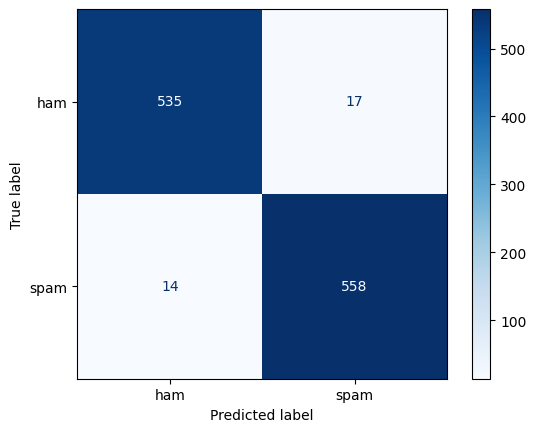

In [13]:
# Get test feature matrix
test_feature_matrix = feature_matrix[test_indices]

# Compute predictions for test data using the same classifier
print("Computing predictions for test data...")
test_predictions = naive_bayes_predict(test_feature_matrix, feature_prob_df)

# Evaluate performance on test set
test_pred_labels = test_predictions.idxmax(axis=1)
test_accuracy = (test_pred_labels == test_data['Spam/Ham'].values).mean()
print(f"Test accuracy: {test_accuracy:.4f}")

# Show confusion matrix for test data
cm_test = confusion_matrix(test_data['Spam/Ham'], test_pred_labels, labels=['ham', 'spam'])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['ham', 'spam'])
disp_test.plot(cmap='Blues')
None

Save your prediction probabilities in "test-predictions.tsv" with the same columns as "train-predictions.tsv".

In [14]:
# Save test predictions to TSV file
test_predictions_output = pd.DataFrame({
    'Message ID': test_data['Message ID'].values,
    'ham': test_predictions['ham'].values,
    'spam': test_predictions['spam'].values
})

test_predictions_output.to_csv('submission/test-predictions.tsv', sep='\t', index=False)
print("Saved test-predictions.tsv")

Saved test-predictions.tsv


Submit "test-predictions.tsv" in Gradescope.

## Part 6: Construct ROC Curve

For every probability threshold from 0.01 to .99 in increments of 0.01, compute the false and true positive rates from the test data using the spam class for positives.
That is, if the predicted spam probability is greater than or equal to the threshold, predict spam.

AUC Score: 0.0230


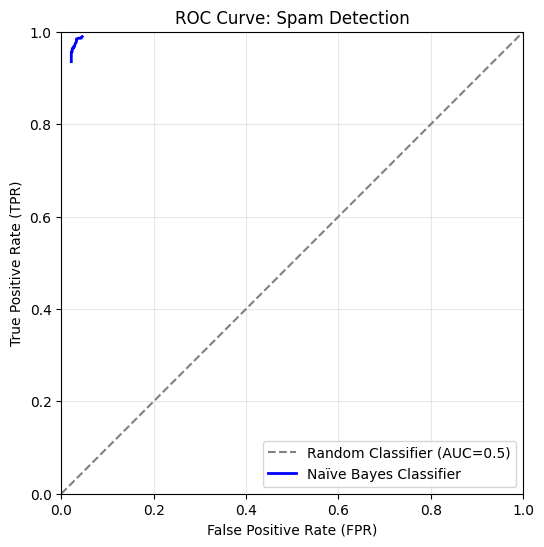

In [ ]:
# Construct ROC curve for spam probability
roc_data = []
thresh = np.arange(0.01, 1.00, 0.01)

for t in thresh:
    # Predict spam if P(spam) >= t
    test_pred_labels_thresh = np.where(test_predictions['spam'] >= t, 'spam', 'ham')

    # Denote positive vs negative
    positive = (test_data['Spam/Ham'] == 'spam')
    negative = (test_data['Spam/Ham'] == 'ham')

    # True positives, false positives
    true_positives = (positive) & (test_pred_labels_thresh == 'spam')
    false_positives = (negative) & (test_pred_labels_thresh == 'spam')

    # Compute the TPR and FPR
    tpr = true_positives.sum() / positive.sum()
    fpr = false_positives.sum() / negative.sum()

    # Store as (FPR, TPR, threshold) for correct plotting
    roc_data.append((fpr, tpr, t))

# Sort by FPR (first element) for proper ROC curve
roc_data.sort()

# Extract FPR and TPR for plotting and AUC calculation
fpr_list = [r[0] for r in roc_data]
tpr_list = [r[1] for r in roc_data]

# Calculate AUC using trapezoidal rule
from sklearn.metrics import auc
auc_score = auc(fpr_list, tpr_list)

# Create enhanced ROC curve visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Fill area under the curve
ax.fill_between(fpr_list, tpr_list, alpha=0.2, color='blue', label=f'AUC = {auc_score:.4f}')

# Plot ROC curve with enhanced styling
ax.plot(fpr_list, tpr_list, label=f"Naïve Bayes Classifier (AUC={auc_score:.4f})", 
        linewidth=3, color='#2E86AB', marker='o', markersize=3, markevery=10)

# Plot diagonal reference line
ax.plot([0, 1], [0, 1], label="Random Classifier (AUC=0.50)", 
        color="gray", linestyle="--", linewidth=2, alpha=0.7)

# Add optimal point annotation (closest to top-left corner)
distances = np.sqrt((np.array(fpr_list) - 0)**2 + (np.array(tpr_list) - 1)**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresh[optimal_idx]
optimal_fpr = fpr_list[optimal_idx]
optimal_tpr = tpr_list[optimal_idx]

ax.plot(optimal_fpr, optimal_tpr, 'r*', markersize=15, 
        label=f'Optimal (threshold={optimal_threshold:.2f})')
ax.annotate(f'TPR={optimal_tpr:.3f}\nFPR={optimal_fpr:.3f}\nThreshold={optimal_threshold:.2f}',
            xy=(optimal_fpr, optimal_tpr), xytext=(optimal_fpr + 0.15, optimal_tpr - 0.15),
            fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red', lw=2))

# Styling
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')
ax.set_title('ROC Curve: Naïve Bayes Spam Classifier\nEnron Email Dataset', 
             fontsize=15, fontweight='bold', pad=20)

# Enhanced grid
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)
ax.set_axisbelow(True)

# Legend with better positioning
ax.legend(loc='lower right', fontsize=11, framealpha=0.95, 
          shadow=True, fancybox=True)

# Add performance text box
textstr = f'Test Set Performance:\n'
textstr += f'Total Samples: {len(test_data)}\n'
textstr += f'Accuracy: {test_accuracy:.2%}\n'
textstr += f'AUC Score: {auc_score:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print(f"ROC Analysis Summary")
print(f"{'='*50}")
print(f"AUC Score: {auc_score:.4f} ({auc_score*100:.2f}%)")
print(f"\nOptimal Operating Point (closest to perfect classifier):")
print(f"  Threshold: {optimal_threshold:.3f}")
print(f"  True Positive Rate: {optimal_tpr:.3f} ({optimal_tpr*100:.1f}%)")
print(f"  False Positive Rate: {optimal_fpr:.3f} ({optimal_fpr*100:.1f}%)")
print(f"\nInterpretation:")
print(f"  - Catches {optimal_tpr*100:.1f}% of spam emails")
print(f"  - Incorrectly flags {optimal_fpr*100:.1f}% of legitimate emails as spam")
print(f"{'='*50}")

Save this data in a file "roc.tsv" with columns threshold, false_positive_rate and true_positive rate.

In [30]:
# Save ROC data to TSV file
roc_df = pd.DataFrame({
    'threshold': thresh,
    'false_positive_rate': fpr_list,
    'true_positive_rate': tpr_list
})

roc_df.to_csv('submission/roc.tsv', sep='\t', index=False)
print("Saved roc.tsv")
print("\nSample ROC data:")
print(roc_df.head(10))
print(f"\nTotal thresholds: {len(roc_df)}")

Saved roc.tsv

Sample ROC data:
   threshold  false_positive_rate  true_positive_rate
0       0.01             0.021739            0.935315
1       0.02             0.021739            0.944056
2       0.03             0.021739            0.945804
3       0.04             0.021739            0.949301
4       0.05             0.021739            0.954545
5       0.06             0.021739            0.956294
6       0.07             0.021739            0.956294
7       0.08             0.021739            0.956294
8       0.09             0.021739            0.956294
9       0.10             0.023551            0.956294

Total thresholds: 99


Submit "roc.tsv" in Gradescope.

## Part 7: Signup for Gemini API Key

Create a free Gemini API key at https://aistudio.google.com/app/api-keys.
You will need to do this with a personal Google account - it will not work with your BU Google account.
This will not incur any charges unless you configure billing information for the key.

You will be asked to start a Gemini free trial for week 11.
This will not incur any charges unless you exceed expected usage by an order of magnitude.


No submission needed.

## Part 8: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

## Part 9: Acknowledgements

If you discussed this assignment with anyone, please acknowledge them here.
If you did this assignment completely on your own, simply write none below.

If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for. If you did not use any other libraries, simply write none below.

If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy. If you did not use any generative AI tools, simply write none below.